# Previously, on WHAT THE FUCK
In:
- `2022-06-28-injection-and-recovery.ipynb` 
- `2022-06-28-injection-and-recovery-part2.ipynb` 

We used a fuck-tonne of simulations to do an injection and recovery test. It failed, except for primary mass.

We learned:
- Can make do with (bp - rp, M_G) instead of (M_bp, M_rp, M_G)
- Can make do with 10,000 simulations.
- Things did not improve if we used (M1, M2) parameterisation instead of (M1, q) -- as expected, but good to test. 

Now we're going to try APT (Automatic Posterior Transformation) aka https://www.mackelab.org/sbi/reference/#sbi.inference.snpe.snpe_c.SNPE_C


In [4]:
import torch
from sbi import utils
from sbi import analysis
from sbi.inference.base import infer


# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial#:~:text=when%20using%20matplotlib%3A-,Error%20%2315%3A%20Initializing%20libiomp5.,performance%20or%20cause%20incorrect%20results.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [11]:
with open("isochrone_grid.pkl", "rb") as fp:
    data = pickle.load(fp)
    
isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs, [isochrone_bs, isochrone_gs, isochrone_rs] = data
isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs = list(map(np.array, (isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs)))
isochrone_bs, isochrone_gs, isochrone_rs = list(map(np.array, [isochrone_bs, isochrone_gs, isochrone_rs]))

Text(0, 0.5, 'Age')

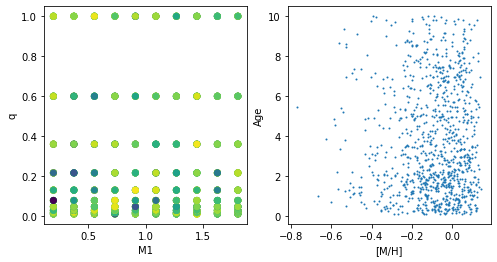

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(
    isochrone_m1s, 
    isochrone_qs,
    c=isochrone_fehs
)
axes[0].set_xlabel("M1")
axes[0].set_ylabel("q")
axes[1].scatter(
    isochrone_fehs,
    isochrone_ages,
    s=1,
)
axes[1].set_xlabel("[M/H]")
axes[1].set_ylabel("Age")

In [7]:
import torch
import numpy as np
from isochrones import get_ichrone

tracks = get_ichrone('mist', tracks=True)

def binary_color_mag_isochrones(
    m1,  # [Solar mass]
    q,   # m2/m1
    age, # [Gyr] 
    fe_h
):
    properties = tracks.generate_binary(
        m1,
        q * m1, 
        np.log10(age) + 9,  
        fe_h,
        bands=["G", "BP", "RP"]
    )
    b_mag = properties.BP_mag.values
    g_mag = properties.G_mag.values
    r_mag = properties.RP_mag.values
    #return np.array([b_mag, g_mag, r_mag]).T[0]
    return np.array([b_mag - r_mag, g_mag]).T[0]


Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [8]:

# Following https://www.mackelab.org/sbi/tutorial/00_getting_started/

print(f"Setting prior")
method = "SNLE"
labels = ("M1", "q", "age", "[M/H]")
bounds = torch.tensor([
    [0.1,  1.8], # M1
    [0.0,    1], # q
    [0.1,   10], # age (Gyr)
    [-1,   0.5]  # metallicity
])
photometric_uncertainty_scale = 1e-4

num_simulations = 10_000

prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

print(f"Emulating posterior")
def simulator(theta):
    z = torch.tensor(binary_color_mag_isochrones(*theta))
    return z + torch.randn(z.shape) * photometric_uncertainty_scale

Setting prior
Emulating posterior


In [9]:
posterior = infer(
    simulator, 
    prior, 
    method=method, 
    num_simulations=num_simulations,
    num_workers=4
)

Running 10000 simulations in 10000 batches.:   0%|                                                    | 0/10000 [00:00<?, ?it/s]Holoviews not imported. Some visualizations will not be available.
Holoviews not imported. Some visualizations will not be available.
Holoviews not imported. Some visualizations will not be available.
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.
PyMultiNest not imported.  MultiNest fits will not work.
PyMultiNest not imported.  MultiNest fits will not work.
PyMultiNest not imported.  MultiNest fits will not work.
Running 10000 simulations in 10000 batches.: 100%|███████████████████████████████████████| 10000/10000 [00:37<00:00, 264.43it/s]


 Neural network successfully converged after 133 epochs.

In [16]:
num_samples = 30
num_tests = len(isochrone_m1s)
num_parameters = len(labels)
percentiles = [16, 50, 84]

all_samples = np.nan * np.ones((num_tests, num_samples, num_parameters))
all_percentiles = np.nan * np.ones((num_tests, num_parameters, len(percentiles)))
all_truths = np.vstack([isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs]).T
all_observations = np.vstack([isochrone_bs - isochrone_rs, isochrone_gs]).T

print(all_samples.shape)
print(all_percentiles.shape)
print(all_truths.shape)
print(all_observations.shape)

(1000, 30, 4)
(1000, 4, 3)
(1000, 4)
(1000, 2)


In [25]:
#np.diff(all_percentiles[0, :], axis=1)

In [31]:
from tqdm import tqdm

for i, observation in enumerate(tqdm(all_observations)):
    if (i % 10) > 0: 
        # can't afford to do 1,000 right now
        continue
    
    if not np.all(np.isfinite(observation)):
        continue
        
    samples = posterior.sample(
        (num_samples,), 
        x=torch.tensor(observation),
        show_progress_bars=False
    )
    all_samples[i] = np.array(samples)
    all_percentiles[i] = np.percentile(samples, percentiles, axis=0).T
    #print(all_truths[i], all_percentiles[i, :, 1])

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:53<00:00,  1.25s/it]


torch.Size([30, 4])

In [14]:
print(all_percentiles.shape)
print(all_truths.shape)

(1000, 4, 3)
(1000, 4)


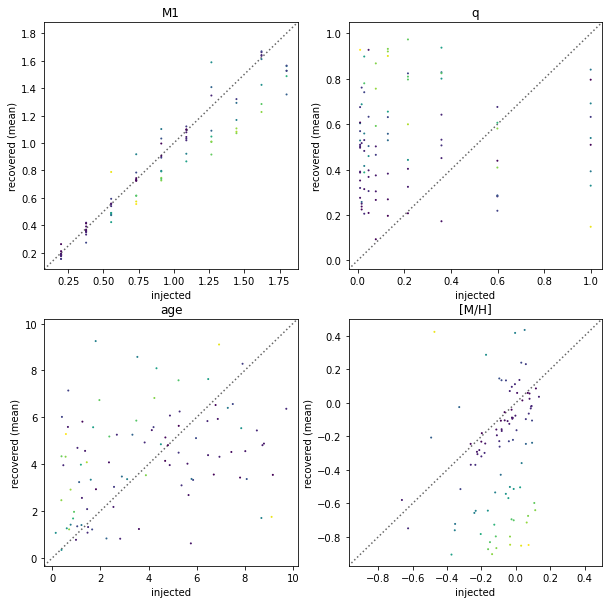

In [32]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
color_index = 3
for i, ax in enumerate(axes.flat):
    ax.scatter(
        all_truths[:, i],
        all_percentiles[:, i, 1],
        s=1,
        c=np.abs(all_truths[:, color_index] - all_percentiles[:, color_index, 1])
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(r"injected")
    ax.set_ylabel(r"recovered (mean)")

In [33]:
# well, that was an expensive waste of time